In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import io
import os
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)

import matplotlib.pyplot as plt
# % matplotlib inline
import seaborn as sns

from sklearn.feature_selection import SelectPercentile, RFE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score, RepeatedStratifiedKFold,\
StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, plot_confusion_matrix, precision_recall_curve, plot_precision_recall_curve, confusion_matrix, recall_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
!pip install category_encoders
import category_encoders as ce
from scipy import stats

from google.colab import drive
drive.mount('/content/gdrive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 1.5 MB/s 
Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My Drive/

/content/gdrive/My Drive


In [ ]:
pwd

'/content/gdrive/My Drive'

#**Load Dataset**

In [ ]:
lung = pd.read_csv("lung.csv")
lung

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
0,3.0,306,2,74,1,1.0,90.0,100.0,1175.0,NaN
1,3.0,455,2,68,1,0.0,90.0,90.0,1225.0,15.0
2,3.0,1010,1,56,1,0.0,90.0,90.0,NaN,15.0
3,5.0,210,2,57,1,1.0,90.0,60.0,1150.0,11.0
4,1.0,883,2,60,1,0.0,100.0,90.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...
223,1.0,188,1,77,1,1.0,80.0,60.0,NaN,3.0
224,13.0,191,1,39,1,0.0,90.0,90.0,2350.0,-5.0
225,32.0,105,1,75,2,2.0,60.0,70.0,1025.0,5.0
226,6.0,174,1,66,1,1.0,90.0,100.0,1075.0,1.0


In [ ]:
lung.shape

(228, 10)

**Variable Description**
- inst = institution code
- time = Survival time in days
- status = Censoring, 0 : Censored; 1 : Dead
- age = Age in years
- sex = 0 : Male; 1 : Female
- ph.ecog = ECOG performance score as rated by the physician. 0 asymptomatic, 1 = symmptomatic but completelu ambulatory, 2 = in bed < 50% of the day, 3 = in bed > 50% of the day but not bedbound, 4 = bedbound
- ph.karno = Karnofsky performance scroe (bad=0 - good=100) rated by physician
pat.karno = Karnofsky performance score as rated by patient
- meal.cal = Calories consumed at meals
- wt.loss = Weight loss in last six mounths

In [ ]:
lung = lung.drop('inst', axis=1)
lung['status'] = lung['status'] - 1
lung['sex'] = lung['sex'] - 1
lung.head()

,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
0,306,1,74,0,1.0,90.0,100.0,1175.0,NaN
1,455,1,68,0,0.0,90.0,90.0,1225.0,15.0
2,1010,0,56,0,0.0,90.0,90.0,NaN,15.0
3,210,1,57,0,1.0,90.0,60.0,1150.0,11.0
4,883,1,60,0,0.0,100.0,90.0,NaN,0.0


In [ ]:
lung.dtypes

time           int64
status         int64
age            int64
sex            int64
ph.ecog      float64
ph.karno     float64
pat.karno    float64
meal.cal     float64
wt.loss      float64
dtype: object

In [ ]:
lung.isnull().sum()

time          0
status        0
age           0
sex           0
ph.ecog       1
ph.karno      1
pat.karno     3
meal.cal     47
wt.loss      14
dtype: int64

In [ ]:
lung.columns

Index(['time', 'status', 'age', 'sex', 'ph.ecog', 'ph.karno', 'pat.karno',
       'meal.cal', 'wt.loss'],
      dtype='object')

In [ ]:
lung['ph.karno'].fillna(lung['ph.karno'].mean(), inplace=True)
lung['pat.karno'].fillna(lung['pat.karno'].mean(), inplace=True)
lung['meal.cal'].fillna(lung['meal.cal'].mean(), inplace=True)
lung['wt.loss'].fillna(lung['wt.loss'].mean(), inplace=True)
lung.dropna(inplace=True) # dropna from ecog, because it's categorical and can't fill with mean
lung['ph.ecog'] = lung['ph.ecog'].astype('int64') # change it to int

In [ ]:
lung.head()

,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
0,306,1,74,0,1,90.0,100.0,1175.000000,9.831776
1,455,1,68,0,0,90.0,90.0,1225.000000,15.000000
2,1010,0,56,0,0,90.0,90.0,928.779006,15.000000
3,210,1,57,0,1,90.0,60.0,1150.000000,11.000000
4,883,1,60,0,0,100.0,90.0,928.779006,0.000000


In [ ]:
lung.isnull().sum()

time         0
status       0
age          0
sex          0
ph.ecog      0
ph.karno     0
pat.karno    0
meal.cal     0
wt.loss      0
dtype: int64

In [ ]:
lung.shape

(227, 9)

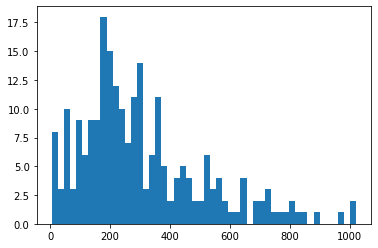

In [ ]:
T = lung['time']
E = lung['status']
plt.hist(T, bins=50)
plt.show()

#**Fitting a non-parametric model Kaplan Meier Curve**

In [ ]:
!pip install lifelines
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines.utils import median_survival_times

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 349 kB 5.1 MB/s 
     |████████████████████████████████| 76 kB 2.7 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4048 sha256=df2f73cb61fddd4ad4f06dfb70ad3ab88be5eb8cf86bb2102ae79ee7bc8e99c4
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.1.0 requires typing-extensions<4.2.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 

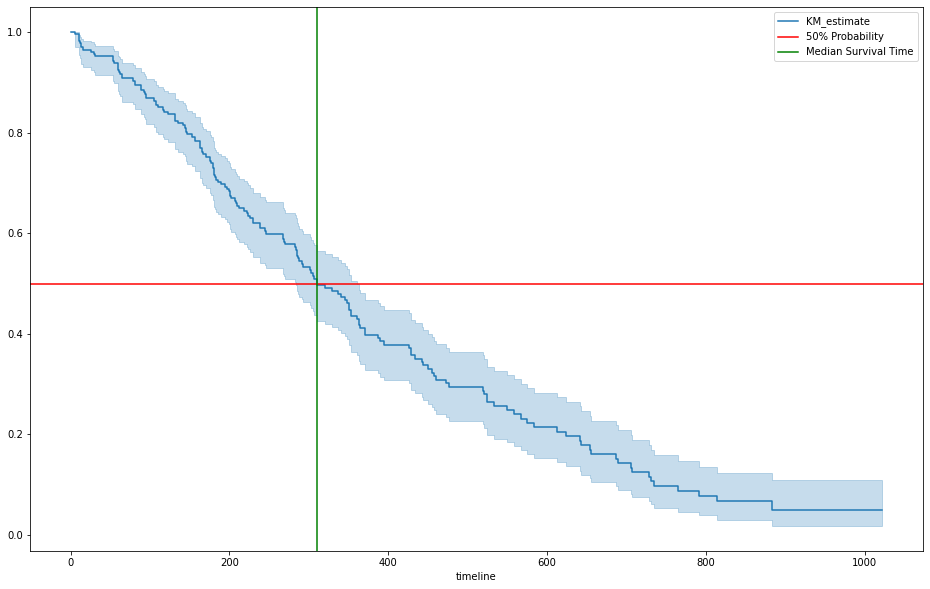

In [ ]:
from IPython.core.pylabtools import figsize
kmf = KaplanMeierFitter()
kmf.fit(durations=T, event_observed=E)
kmf.plot_survival_function(figsize=(16,10))
plt.axhline(0.5, label='50% Probability', color='red')
plt.axvline(kmf.median_survival_time_, label='Median Survival Time', color='green')
plt.legend()
plt.show()

# this shows the probabilities of the event occurs in particular period (days)
# for example, what is the probabilities of people will die in day 400? It's nearly 40%.

In [ ]:
kmf.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,227,227
5.0,1,1,0,0,227
11.0,3,3,0,0,226
12.0,1,1,0,0,223
13.0,2,2,0,0,222
...,...,...,...,...,...
840.0,1,0,1,0,5
883.0,1,1,0,0,4
965.0,1,0,1,0,3


#**Plot Kaplan-Meier Survival Function**

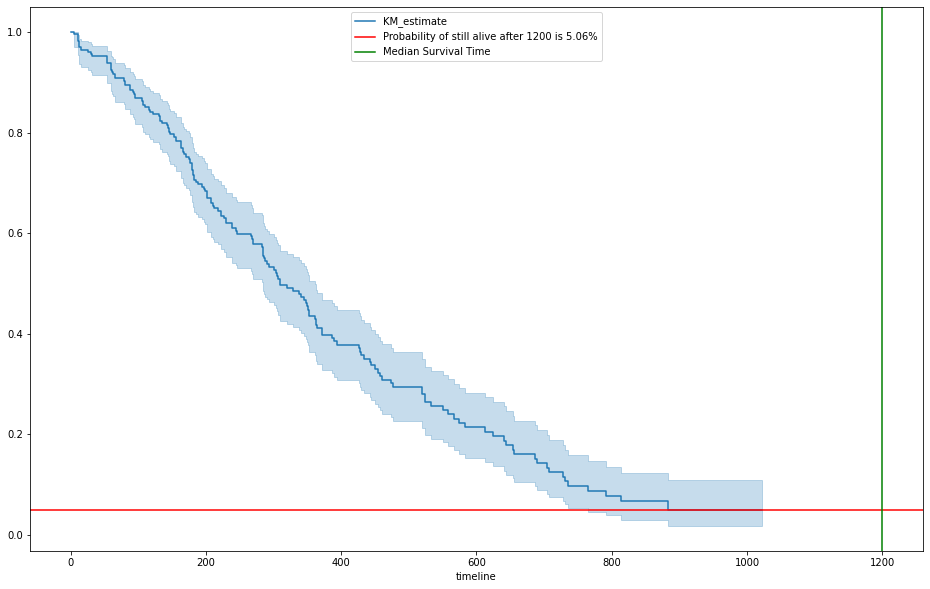

In [ ]:
from IPython.core.pylabtools import figsize

after_day = 1200 # particular day we want to know the probability of survive
prob = kmf.predict(after_day) # predict the probability a patient still survive after d-th day

kmf.plot_survival_function(figsize=(16,10))
plt.axhline(prob, label=f'Probability of still alive after {after_day} is {round(prob*100,2)}%', color='red')
plt.axvline(after_day, label='Median Survival Time', color='green')
plt.legend()
plt.show()

#**Plot Kaplan-Meier Cumulative Density**

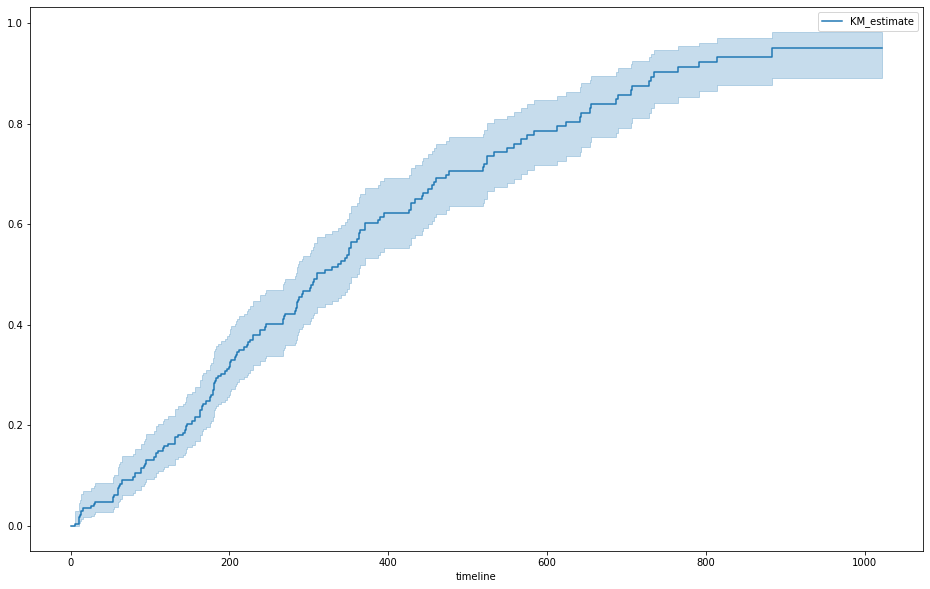

In [ ]:
kmf.plot_cumulative_density(figsize=(16,10))
plt.show()

# notice that, as the survival days increase, the probability of patient dying, increases as well.
# basically it's just the opposite of survival_function

In [ ]:
kmf.cumulative_density_

,KM_estimate
timeline,
0.0,0.000000
5.0,0.004405
11.0,0.017621
12.0,0.022026
13.0,0.030837
...,...
840.0,0.932577
883.0,0.949433
965.0,0.949433


In [ ]:
event_at = kmf.event_table.loc[394,:]
surv_at_event = (event_at.at_risk - event_at.observed)/event_at.at_risk
display(event_at)
surv_at_event

removed      1
observed     1
censored     0
entrance     0
at_risk     58
Name: 394.0, dtype: int64

0.9827586206896551

In [ ]:
kmf.median_survival_time_

# this explains when is the life chance is 50-50.

310.0

In [ ]:
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print(median_)
print(median_confidence_interval_)

310.0
     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                   284.0                   361.0


#**Separate analysis by gender**

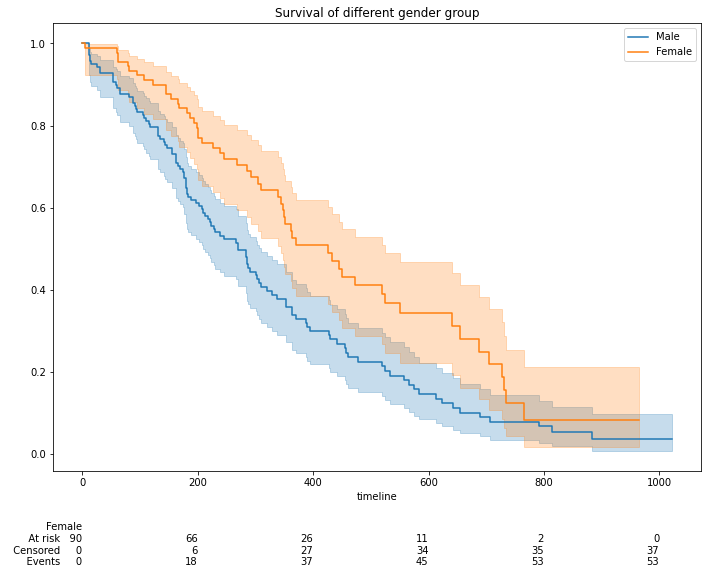

In [ ]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111)
male = (lung['sex'] == 0)
kmf.fit(durations = T[male], event_observed = E[male], label='Male')
kmf.plot_survival_function(ax = ax)

kmf.fit(durations = T[~male], event_observed = E[~male], label='Female')
kmf.plot_survival_function(ax = ax, at_risk_counts=True)

plt.title("Survival of different gender group")
plt.show()

#**Log Rank Test**

In [ ]:
# H0 : The survival days for male and female is the same
# H1 : The survival days for male and female is different

alpha = 0.05
patient_result = logrank_test(T[male], T[~male], E[male], E[~male])
if patient_result.p_value < 0.05:
  print(f"The p-value is {round(patient_result.p_value,5)}: Reject H0")
else:
  print(f"The p-value is {round(patient_result.p_value,5)}: Failed to reject H0")

The p-value is 0.00156: Reject H0


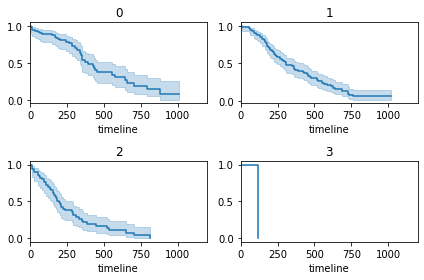

In [ ]:
ecog_types = lung.sort_values(by = ['ph.ecog'])['ph.ecog'].unique()

for i, ecog_types in enumerate(ecog_types):
  ax = plt.subplot(2,2,i+1)
  ix = lung['ph.ecog'] == ecog_types
  kmf.fit(T[ix], E[ix], label = ecog_types)
  kmf.plot_survival_function(ax=ax, legend=False)
  plt.title(ecog_types)
  plt.xlim(0,1200)

plt.tight_layout()

In [ ]:
lung.head()

,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
0,306,1,74,0,1,90.0,100.0,1175.000000,9.831776
1,455,1,68,0,0,90.0,90.0,1225.000000,15.000000
2,1010,0,56,0,0,90.0,90.0,928.779006,15.000000
3,210,1,57,0,1,90.0,60.0,1150.000000,11.000000
4,883,1,60,0,0,100.0,90.0,928.779006,0.000000


In [ ]:
T, E

(0       306
 1       455
 2      1010
 3       210
 4       883
        ... 
 223     188
 224     191
 225     105
 226     174
 227     177
 Name: time, Length: 227, dtype: int64, 0      1
 1      1
 2      0
 3      1
 4      1
       ..
 223    0
 224    0
 225    0
 226    0
 227    0
 Name: status, Length: 227, dtype: int64)

#**Weibull Model**

In [ ]:
from lifelines import WeibullFitter

wb = WeibullFitter()
wb.fit(lung['time'], lung['status'])

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 227 total observations, 63 right-censored observations>

Lambda: 419.54308835994294 ; Rho or k: 1.3227364622560693


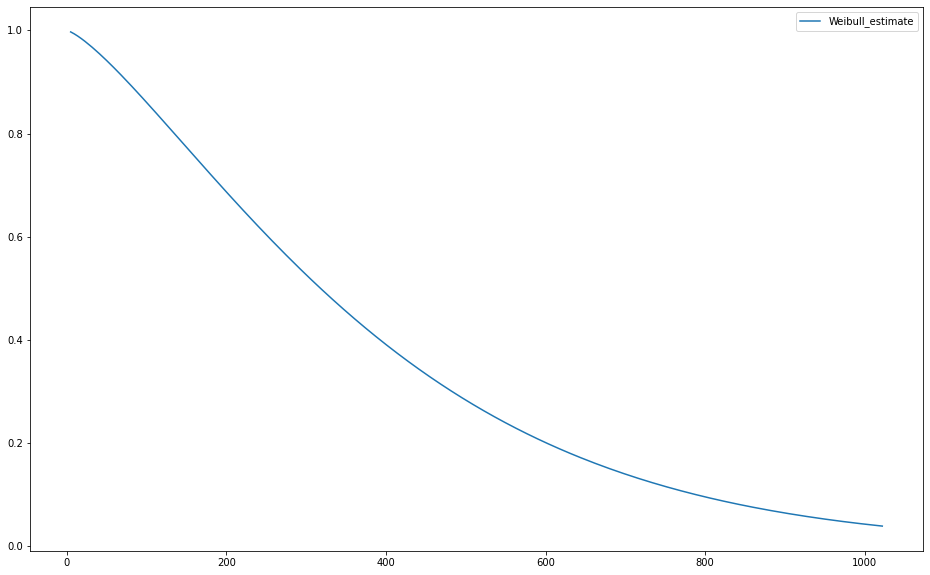

In [ ]:
print('Lambda:', wb.lambda_, '; Rho or k:', wb.rho_)
wb.survival_function_.plot(figsize=(16,10))
plt.show()

# rule of thumb for Rho:
# if Rho < 1, the failure/event rate is decrease over time
# if Rho = 1, the failure/event rate is constant over time
# if Rho > 1, the failure/event rate is increase over time

In [ ]:
wb.predict(1200)*100

1.8040026328179086

#**Weibull Affected Failure Time Model**

In [ ]:
from lifelines import WeibullAFTFitter

aft = WeibullAFTFitter()
aft.fit(df = lung,
        duration_col = "time",
        event_col = "status")
print(aft.summary)

                           coef    exp(coef)  se(coef)  coef lower 95%  \
param   covariate                                                        
lambda_ age       -8.600994e-03     0.991436  0.006725       -0.021782   
        meal.cal  -7.336337e-07     0.999999  0.000172       -0.000338   
        pat.karno  8.921651e-03     1.008962  0.004917       -0.000715   
        ph.ecog   -4.506949e-01     0.637185  0.128602       -0.702751   
        ph.karno  -1.225870e-02     0.987816  0.006592       -0.025178   
        sex        4.190224e-01     1.520474  0.122274        0.179370   
        wt.loss    8.071591e-03     1.008104  0.004702       -0.001145   
        Intercept  7.050759e+00  1153.733991  0.878864        5.328217   
rho_    Intercept  3.397502e-01     1.404597  0.061771        0.218682   

                   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
param   covariate                                                             
lambda_ age              0.

#**Plot Partial Effects on Outcome**

In [ ]:
lung['ph.ecog'].describe()

count    227.000000
mean       0.951542
std        0.717872
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        3.000000
Name: ph.ecog, dtype: float64

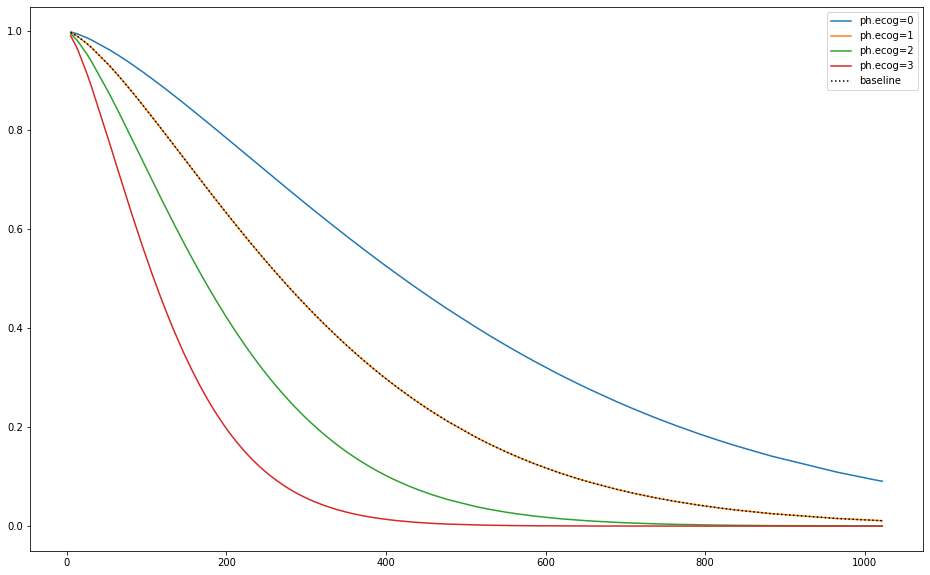

In [ ]:
aft.plot_partial_effects_on_outcome(covariates='ph.ecog',
                                    values=[0,1,2,3],
                                    figsize=(16,10))

In [ ]:
aft_custom = WeibullAFTFitter()
aft_custom.fit(df = lung,
        duration_col = "time",
        event_col = "status",
        formula = "wt.loss + ph.ecog * sex")
print(aft_custom.summary)

                         coef   exp(coef)  se(coef)  coef lower 95%  \
param   covariate                                                     
lambda_ Intercept    6.163386  475.033934  0.121544        5.925164   
        ph.ecog     -0.362441    0.695975  0.101344       -0.561072   
        sex          0.510625    1.666332  0.234730        0.050563   
        wt.loss      0.005930    1.005948  0.004588       -0.003063   
        ph.ecog:sex -0.093597    0.910650  0.180967       -0.448287   
rho_    Intercept    0.316078    1.371737  0.061242        0.196046   

                     coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
param   covariate                                                               
lambda_ Intercept          6.401609           374.339815           602.813885   
        ph.ecog           -0.163811             0.570597             0.848903   
        sex                0.970687             1.051864             2.639756   
        wt.loss           

#**Predict using the model**

In [ ]:
lung_samp = lung.drop(['time', 'status'], axis=1).sample(10)
lung_pred = aft.predict_median(lung_samp)

In [ ]:
lung_samp['pred'] = lung_pred
lung_samp

,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss,pred
157,62,0,2,70.0,60.0,475.0,27.0,190.555570
193,64,0,1,90.0,80.0,825.0,33.0,288.550079
187,58,0,0,90.0,80.0,1300.0,8.0,389.565227
185,45,1,0,90.0,100.0,975.0,5.0,773.034240
118,66,0,2,70.0,60.0,613.0,24.0,179.688333
25,70,1,1,90.0,80.0,825.0,6.0,335.074248
186,72,1,2,70.0,90.0,463.0,20.0,328.360975
46,74,0,0,90.0,70.0,463.0,30.0,371.068970
18,56,1,2,60.0,60.0,238.0,10.0,300.700888
42,59,1,0,90.0,90.0,363.0,27.0,748.983458


In [ ]:
lung_pred_prob = aft.predict_survival_function(lung_samp)
lung_pred_prob = lung_pred_prob.T
lung_pred_prob

,5.0,11.0,12.0,13.0,15.0,26.0,30.0,31.0,53.0,54.0,59.0,60.0,61.0,62.0,65.0,79.0,81.0,88.0,92.0,93.0,95.0,105.0,107.0,110.0,116.0,118.0,122.0,131.0,132.0,135.0,142.0,144.0,145.0,147.0,153.0,156.0,163.0,166.0,167.0,170.0,173.0,174.0,175.0,176.0,177.0,179.0,180.0,181.0,182.0,183.0,185.0,186.0,188.0,189.0,191.0,192.0,194.0,196.0,197.0,199.0,201.0,202.0,203.0,207.0,208.0,210.0,211.0,212.0,218.0,221.0,222.0,223.0,224.0,225.0,226.0,229.0,230.0,235.0,237.0,239.0,240.0,243.0,245.0,246.0,252.0,259.0,266.0,267.0,268.0,269.0,270.0,272.0,276.0,279.0,283.0,284.0,285.0,286.0,288.0,291.0,292.0,293.0,296.0,300.0,301.0,303.0,305.0,306.0,310.0,315.0,320.0,329.0,332.0,337.0,340.0,345.0,348.0,350.0,351.0,353.0,356.0,361.0,363.0,364.0,371.0,376.0,382.0,384.0,387.0,390.0,394.0,404.0,413.0,426.0,428.0,429.0,433.0,442.0,444.0,450.0,455.0,457.0,458.0,460.0,473.0,477.0,511.0,519.0,520.0,524.0,529.0,533.0,543.0,550.0,551.0,558.0,559.0,567.0,574.0,583.0,588.0,613.0,624.0,641.0,643.0,654.0,655.0,687.0,689.0,705.0,707.0,728.0,731.0,735.0,740.0,765.0,791.0,806.0,814.0,821.0,840.0,883.0,965.0,1010.0,1022.0
157,0.995839,0.987460,0.985841,0.984169,0.980679,0.958634,0.949661,0.947352,0.891477,0.888757,0.874983,0.872196,0.869399,0.866592,0.858119,0.817716,0.811855,0.791228,0.779381,0.776414,0.770476,0.740742,0.734796,0.725882,0.708093,0.702178,0.690377,0.663999,0.661086,0.652370,0.632183,0.626458,0.623602,0.617907,0.600950,0.592548,0.573152,0.564934,0.562208,0.554068,0.545990,0.543311,0.540638,0.537973,0.535315,0.530020,0.527383,0.524754,0.522132,0.519517,0.514309,0.511716,0.506553,0.503983,0.498865,0.496318,0.491246,0.486206,0.483697,0.478703,0.473741,0.471271,0.468810,0.459045,0.456623,0.451805,0.449408,0.447020,0.432860,0.425891,0.423585,0.421287,0.418997,0.416716,0.414443,0.407674,0.405434,0.394363,0.389993,0.385657,0.383502,0.377087,0.372852,0.370747,0.358297,0.344155,0.330425,0.328497,0.326577,0.324666,0.322763,0.318982,0.311520,0.306010,0.298779,0.296991,0.295212,0.293441,0.289923,0.284708,0.282985,0.281271,0.276176,0.269495,0.267844,0.264567,0.261321,0.259710,0.253344,0.245560,0.237967,0.224775,0.220511,0.213550,0.209459,0.202785,0.198864,0.196285,0.195006,0.192468,0.188713,0.182589,0.180186,0.178995,0.170836,0.165201,0.158646,0.156511,0.153353,0.150249,0.146193,0.136460,0.128179,0.116983,0.115338,0.114523,0.111312,0.104374,0.102884,0.098526,0.095018,0.093646,0.092967,0.091621,0.083283,0.080856,0.062632,0.058919,0.058469,0.056700,0.054557,0.052895,0.048938,0.046329,0.045967,0.043503,0.043161,0.040511,0.038315,0.035651,0.034245,0.027947,0.025529,0.022169,0.021802,0.019881,0.019714,0.015018,0.014762,0.012857,0.012636,0.010518,0.010244,0.009890,0.009462,0.007573,0.005989,0.005223,0.004854,0.004551,0.003816,0.002546,0.001152,0.000736,0.000653
193,0.997675,0.992979,0.992070,0.991130,0.989166,0.976689,0.971574,0.970254,0.937875,0.936276,0.928146,0.926495,0.924835,0.923167,0.918116,0.893723,0.890142,0.877443,0.870083,0.868232,0.864518,0.845728,0.841931,0.836214,0.824709,0.820855,0.813124,0.795629,0.793678,0.787818,0.774113,0.770191,0.768229,0.764303,0.752521,0.746628,0.732883,0.726997,0.725036,0.719156,0.713283,0.711326,0.709371,0.707416,0.705463,0.701558,0.699607,0.697658,0.695709,0.693762,0.689870,0.687926,0.684042,0.682102,0.678226,0.676290,0.672423,0.668562,0.666634,0.662782,0.658937,0.657017,0.655099,0.647445,0.645536,0.641724,0.639821,0.637920,0.626558,0.620905,0.619026,0.617149,0.615274,0.613401,0.611531,0.605934,0.604073,0.594807,0.591118,0.587440,0.585604,0.580115,0.576468,0.574649,0.563793,0.551258,0.538869,0.537111,0.535356,0.533605,0.531856,0.528369,0.521431,0.516262,0.509414,0.507710,0.506010,0.504313,0.500929,0.495877,0.494200,0.492526,0.487525,0.480904,0.479257,0.475974,0.472705,0.471076,0.464593,0.456568,0.448632,0.434571,0.429948,0.422316,0.417781,0.410295,0.405847,0.402899,0.401431,0.398506,0.394146,0.386953,0.384101,0.382681,0.372842,0.365925,0.357746,0.355049,0.351031,0.347046,0.341785,0.328886,0.317590,0.301789,0.299412,0.298229,0.293532,0.2

In [ ]:
lung_samp.join(lung_pred_prob)

,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss,pred,5.0,11.0,12.0,13.0,15.0,26.0,30.0,31.0,53.0,54.0,59.0,60.0,61.0,62.0,65.0,79.0,81.0,88.0,92.0,93.0,95.0,105.0,107.0,110.0,116.0,118.0,122.0,131.0,132.0,135.0,142.0,144.0,145.0,147.0,153.0,156.0,163.0,166.0,167.0,170.0,173.0,174.0,175.0,176.0,177.0,179.0,180.0,181.0,182.0,183.0,185.0,186.0,188.0,189.0,191.0,192.0,194.0,196.0,197.0,199.0,201.0,202.0,203.0,207.0,208.0,210.0,211.0,212.0,218.0,221.0,222.0,223.0,224.0,225.0,226.0,229.0,230.0,235.0,237.0,239.0,240.0,243.0,245.0,246.0,252.0,259.0,266.0,267.0,268.0,269.0,270.0,272.0,276.0,279.0,283.0,284.0,285.0,286.0,288.0,291.0,292.0,293.0,296.0,300.0,301.0,303.0,305.0,306.0,310.0,315.0,320.0,329.0,332.0,337.0,340.0,345.0,348.0,350.0,351.0,353.0,356.0,361.0,363.0,364.0,371.0,376.0,382.0,384.0,387.0,390.0,394.0,404.0,413.0,426.0,428.0,429.0,433.0,442.0,444.0,450.0,455.0,457.0,458.0,460.0,473.0,477.0,511.0,519.0,520.0,524.0,529.0,533.0,543.0,550.0,551.0,558.0,559.0,567.0,574.0,583.0,588.0,613.0,624.0,641.0,643.0,654.0,655.0,687.0,689.0,705.0,707.0,728.0,731.0,735.0,740.0,765.0,791.0,806.0,814.0,821.0,840.0,883.0,965.0,1010.0,1022.0
157,62,0,2,70.0,60.0,475.0,27.0,190.555570,0.995839,0.987460,0.985841,0.984169,0.980679,0.958634,0.949661,0.947352,0.891477,0.888757,0.874983,0.872196,0.869399,0.866592,0.858119,0.817716,0.811855,0.791228,0.779381,0.776414,0.770476,0.740742,0.734796,0.725882,0.708093,0.702178,0.690377,0.663999,0.661086,0.652370,0.632183,0.626458,0.623602,0.617907,0.600950,0.592548,0.573152,0.564934,0.562208,0.554068,0.545990,0.543311,0.540638,0.537973,0.535315,0.530020,0.527383,0.524754,0.522132,0.519517,0.514309,0.511716,0.506553,0.503983,0.498865,0.496318,0.491246,0.486206,0.483697,0.478703,0.473741,0.471271,0.468810,0.459045,0.456623,0.451805,0.449408,0.447020,0.432860,0.425891,0.423585,0.421287,0.418997,0.416716,0.414443,0.407674,0.405434,0.394363,0.389993,0.385657,0.383502,0.377087,0.372852,0.370747,0.358297,0.344155,0.330425,0.328497,0.326577,0.324666,0.322763,0.318982,0.311520,0.306010,0.298779,0.296991,0.295212,0.293441,0.289923,0.284708,0.282985,0.281271,0.276176,0.269495,0.267844,0.264567,0.261321,0.259710,0.253344,0.245560,0.237967,0.224775,0.220511,0.213550,0.209459,0.202785,0.198864,0.196285,0.195006,0.192468,0.188713,0.182589,0.180186,0.178995,0.170836,0.165201,0.158646,0.156511,0.153353,0.150249,0.146193,0.136460,0.128179,0.116983,0.115338,0.114523,0.111312,0.104374,0.102884,0.098526,0.095018,0.093646,0.092967,0.091621,0.083283,0.080856,0.062632,0.058919,0.058469,0.056700,0.054557,0.052895,0.048938,0.046329,0.045967,0.043503,0.043161,0.040511,0.038315,0.035651,0.034245,0.027947,0.025529,0.022169,0.021802,0.019881,0.019714,0.015018,0.014762,0.012857,0.012636,0.010518,0.010244,0.009890,0.009462,0.007573,0.005989,0.005223,0.004854,0.004551,0.003816,0.002546,0.001152,0.000736,0.000653
193,64,0,1,90.0,80.0,825.0,33.0,288.550079,0.997675,0.992979,0.992070,0.991130,0.989166,0.976689,0.971574,0.970254,0.937875,0.936276,0.928146,0.926495,0.924835,0.923167,0.918116,0.893723,0.890142,0.877443,0.870083,0.868232,0.864518,0.845728,0.841931,0.836214,0.824709,0.820855,0.813124,0.795629,0.793678,0.787818,0.774113,0.770191,0.768229,0.764303,0.752521,0.746628,0.732883,0.726997,0.725036,0.719156,0.713283,0.711326,0.709371,0.707416,0.705463,0.701558,0.699607,0.697658,0.695709,0.693762,0.689870,0.687926,0.684042,0.682102,0.678226,0.676290,0.672423,0.668562,0.666634,0.662782,0.658937,0.657017,0.655099,0.647445,0.645536,0.641724,0.639821,0.637920,0.626558,0.620905,0.619026,0.617149,0.615274,0.613401,0.611531,0.605934,0.604073,0.594807,0.591118,0.587440,0.585604,0.580115,0.576468,0.574649,0.563793,0.551258,0.538869,0.537111,0.535356,0.533605,0.531856,0.528369,0.521431,0.516262,0.509414,0.507710,0.506010,0.504313,0.500929,0.495877,0.494200,0.492526,0.487525,0.480904,0.479257,0.475974,0.472705,0.471076,0.464593,0.456568,0.448632,0.434571,0.429948,0.422316,0.417781,0.410295,0.405847,0.402899,0.401431,0.398506,0.394146,0.386953,0.3

#**How to choose best model**

## **AIC**

In [ ]:
from lifelines import WeibullFitter,\
                      ExponentialFitter,\
                      LogNormalFitter

D = lung['time']
E = lung['status']

wb = WeibullFitter().fit(D, E)
ep = ExponentialFitter().fit(D, E)
ln = LogNormalFitter().fit(D, E)

print(wb.AIC_, ep.AIC_, ln.AIC_)

2298.8561137465936 2314.2465289315023 2330.351968846968


## **.find_best_parametric_model()**

In [ ]:
from lifelines.utils import find_best_parametric_model

best_model, best_aic = find_best_parametric_model(D, E, 'AIC')
print(best_model)
print(best_aic)

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 227 total observations, 63 right-censored observations>
2298.8561137465936


## **qq plot**

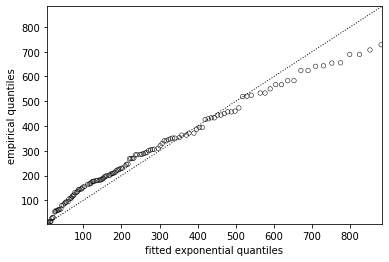

In [ ]:
from lifelines.plotting import qq_plot

WeibullFitter().fit(D, E)
qq_plot(model)
plt.show()